# Convolutional VAE vs DCGAN on CIFAR-10
## Midterm Project: Comparative Analysis of Generative Models

This notebook implements and compares:
1. Convolutional Variational Autoencoder (VAE)
2. Deep Convolutional GAN (DCGAN)

Both models are trained on CIFAR-10 and evaluated on reconstruction quality, representation learning, and sample generation.

## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import os
import random
from tqdm import tqdm
import json

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device configuration (supports CUDA, MPS for M1 Macs, and CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

# Create directories
os.makedirs('results', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('figures', exist_ok=True)

Using device: mps


## 2. Data Loading and Preprocessing

100%|██████████| 170498071/170498071 [00:18<00:00, 9163788.17it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Using subset of 10000 training samples
Training samples: 10000
Test samples: 10000


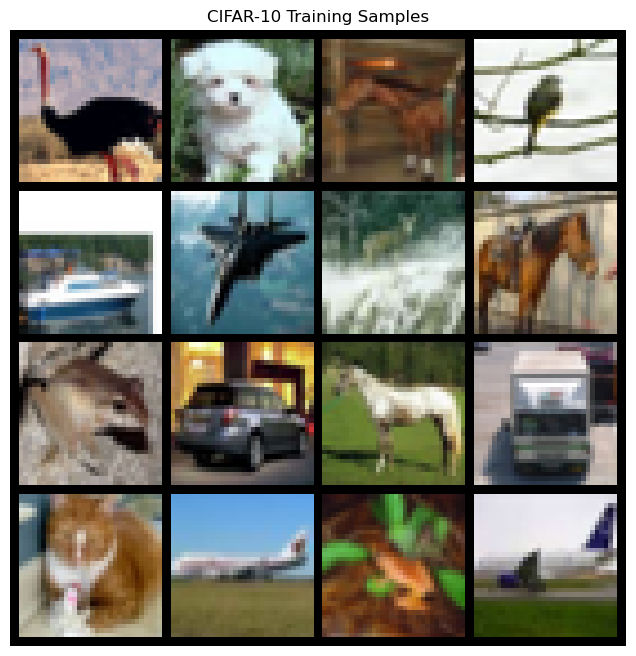

In [2]:
# CIFAR-10 dataset parameters
IMAGE_SIZE = 32
NUM_CLASSES = 10
BATCH_SIZE = 64  # Reduced for M1 Mac compatibility (128 on high-end GPUs)
USE_SUBSET = True  # Using 10k subset for faster training on M1 (as allowed for "GPU scarce")

# Data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load CIFAR-10
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

# Use subset if needed
if USE_SUBSET:
    train_indices = random.sample(range(len(train_dataset)), 10000)
    train_dataset = Subset(train_dataset, train_indices)
    print(f"Using subset of {len(train_dataset)} training samples")

# Create data loaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Visualize some samples
def show_images(images, title="Images"):
    images = images * 0.5 + 0.5  # Denormalize
    grid = make_grid(images[:16], nrow=4)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.title(title)
    plt.axis('off')
    plt.show()

# Show sample images
sample_batch, _ = next(iter(train_loader))
show_images(sample_batch, "CIFAR-10 Training Samples")

## 3. Convolutional VAE Implementation

In [3]:
class ConvVAE(nn.Module):
    """Convolutional Variational Autoencoder"""
    
    def __init__(self, latent_dim=64, image_channels=3):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder: 32x32 -> 16x16 -> 8x8 -> 4x4
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2, padding=1),  # 32 -> 16
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 16 -> 8
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 8 -> 4
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )
        
        # Latent space parameters
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        
        # Decoder input
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4)
        
        # Decoder: 4x4 -> 8x8 -> 16x16 -> 32x32
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 4 -> 8
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 8 -> 16
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2, padding=1),  # 16 -> 32
            nn.Tanh()  # Output in [-1, 1]
        )
    
    def encode(self, x):
        """Encode input to latent distribution parameters"""
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        """Decode latent vector to image"""
        h = self.fc_decode(z)
        h = h.view(h.size(0), 128, 4, 4)
        return self.decoder(h)
    
    def forward(self, x):
        """Forward pass through VAE"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """VAE loss = Reconstruction loss + KL divergence"""
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') / x.size(0)
    
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    
    # Total loss (ELBO)
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss, kl_loss

# Initialize VAE
vae = ConvVAE(latent_dim=64).to(device)
print(f"VAE Parameters: {sum(p.numel() for p in vae.parameters())/1e6:.2f}M")

VAE Parameters: 0.73M


## 4. DCGAN Implementation

In [4]:
class Generator(nn.Module):
    """DCGAN Generator"""
    
    def __init__(self, z_dim=100, image_channels=3):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        
        # Project and reshape: z -> 4x4 feature map
        self.fc = nn.Linear(z_dim, 128 * 4 * 4)
        
        # Decoder: 4x4 -> 8x8 -> 16x16 -> 32x32
        self.main = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),  # 4 -> 8
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8 -> 16
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, image_channels, kernel_size=4, stride=2, padding=1),  # 16 -> 32
            nn.Tanh()
        )
    
    def forward(self, z):
        h = self.fc(z)
        h = h.view(h.size(0), 128, 4, 4)
        return self.main(h)

class Discriminator(nn.Module):
    """DCGAN Discriminator"""
    
    def __init__(self, image_channels=3):
        super(Discriminator, self).__init__()
        
        # Encoder: 32x32 -> 16x16 -> 8x8 -> 4x4
        self.main = nn.Sequential(
            nn.Conv2d(image_channels, 64, kernel_size=4, stride=2, padding=1),  # 32 -> 16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16 -> 8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8 -> 4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.fc = nn.Linear(256 * 4 * 4, 1)
    
    def forward(self, x):
        h = self.main(x)
        h = h.view(h.size(0), -1)
        return self.fc(h)

# Initialize GAN
generator = Generator(z_dim=100).to(device)
discriminator = Discriminator().to(device)

print(f"Generator Parameters: {sum(p.numel() for p in generator.parameters())/1e6:.2f}M")
print(f"Discriminator Parameters: {sum(p.numel() for p in discriminator.parameters())/1e6:.2f}M")

Generator Parameters: 0.60M
Discriminator Parameters: 0.66M


## 5. Training Functions

In [5]:
def train_vae(model, train_loader, epochs=20, beta=1.0, lr=1e-3):
    """Train VAE model"""
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    
    history = {'total_loss': [], 'recon_loss': [], 'kl_loss': []}
    
    model.train()
    for epoch in range(epochs):
        total_loss_epoch = 0
        recon_loss_epoch = 0
        kl_loss_epoch = 0
        
        pbar = tqdm(train_loader, desc=f'VAE Epoch {epoch+1}/{epochs}')
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            
            optimizer.zero_grad()
            recon, mu, logvar = model(data)
            loss, recon_loss, kl_loss = vae_loss(recon, data, mu, logvar, beta=beta)
            loss.backward()
            optimizer.step()
            
            total_loss_epoch += loss.item()
            recon_loss_epoch += recon_loss.item()
            kl_loss_epoch += kl_loss.item()
            
            pbar.set_postfix({
                'loss': loss.item(),
                'recon': recon_loss.item(),
                'kl': kl_loss.item()
            })
        
        # Average losses
        n_batches = len(train_loader)
        history['total_loss'].append(total_loss_epoch / n_batches)
        history['recon_loss'].append(recon_loss_epoch / n_batches)
        history['kl_loss'].append(kl_loss_epoch / n_batches)
        
        print(f"Epoch {epoch+1}: Total Loss = {history['total_loss'][-1]:.4f}, "
              f"Recon = {history['recon_loss'][-1]:.4f}, KL = {history['kl_loss'][-1]:.4f}")
    
    return history

def train_gan(generator, discriminator, train_loader, epochs=50, z_dim=100, lr=2e-4):
    """Train DCGAN model"""
    # Optimizers with different betas for GANs
    optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    criterion = nn.BCEWithLogitsLoss()
    
    history = {'d_loss': [], 'g_loss': []}
    
    generator.train()
    discriminator.train()
    
    for epoch in range(epochs):
        d_loss_epoch = 0
        g_loss_epoch = 0
        
        pbar = tqdm(train_loader, desc=f'GAN Epoch {epoch+1}/{epochs}')
        for batch_idx, (real_images, _) in enumerate(pbar):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            # Labels
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            
            # Train Discriminator
            optimizer_d.zero_grad()
            
            # Real images
            real_outputs = discriminator(real_images)
            d_loss_real = criterion(real_outputs, real_labels)
            
            # Fake images
            z = torch.randn(batch_size, z_dim).to(device)
            fake_images = generator(z)
            fake_outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(fake_outputs, fake_labels)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()
            
            # Train Generator
            optimizer_g.zero_grad()
            
            z = torch.randn(batch_size, z_dim).to(device)
            fake_images = generator(z)
            fake_outputs = discriminator(fake_images)
            g_loss = criterion(fake_outputs, real_labels)
            
            g_loss.backward()
            optimizer_g.step()
            
            d_loss_epoch += d_loss.item()
            g_loss_epoch += g_loss.item()
            
            pbar.set_postfix({
                'd_loss': d_loss.item(),
                'g_loss': g_loss.item()
            })
        
        # Average losses
        n_batches = len(train_loader)
        history['d_loss'].append(d_loss_epoch / n_batches)
        history['g_loss'].append(g_loss_epoch / n_batches)
        
        print(f"Epoch {epoch+1}: D Loss = {history['d_loss'][-1]:.4f}, "
              f"G Loss = {history['g_loss'][-1]:.4f}")
    
    return history

## 6. Train VAE

In [6]:
VAE_EPOCHS = 20  # Within allowed range 15-30
VAE_BETA = 1.0  # Standard ELBO

print("Training VAE...")
vae_history = train_vae(vae, train_loader, epochs=VAE_EPOCHS, beta=VAE_BETA, lr=1e-3)

# Save VAE checkpoint
torch.save({
    'model_state_dict': vae.state_dict(),
    'history': vae_history,
    'hyperparameters': {
        'latent_dim': 64,
        'beta': VAE_BETA,
        'epochs': VAE_EPOCHS,
        'lr': 1e-3,
        'seed': SEED
    }
}, 'checkpoints/vae_model.pth')

print("VAE training complete!")

Training VAE...


VAE Epoch 1/20: 100%|██████████| 157/157 [00:31<00:00,  4.99it/s, loss=435, recon=382, kl=53]        


Epoch 1: Total Loss = 417.5045, Recon = 372.4940, KL = 45.0105


VAE Epoch 2/20: 100%|██████████| 157/157 [00:20<00:00,  7.68it/s, loss=283, recon=222, kl=60.6]


Epoch 2: Total Loss = 270.9973, Recon = 219.3615, KL = 51.6358


VAE Epoch 3/20: 100%|██████████| 157/157 [00:22<00:00,  7.13it/s, loss=237, recon=183, kl=53.3]


Epoch 3: Total Loss = 245.3975, Recon = 191.9638, KL = 53.4337


VAE Epoch 4/20: 100%|██████████| 157/157 [00:23<00:00,  6.83it/s, loss=277, recon=220, kl=57.7]


Epoch 4: Total Loss = 233.9332, Recon = 179.5198, KL = 54.4134


VAE Epoch 5/20: 100%|██████████| 157/157 [00:25<00:00,  6.10it/s, loss=199, recon=142, kl=57.3]


Epoch 5: Total Loss = 226.1842, Recon = 170.7220, KL = 55.4621


VAE Epoch 6/20: 100%|██████████| 157/157 [00:23<00:00,  6.59it/s, loss=240, recon=174, kl=66.1]


Epoch 6: Total Loss = 219.4610, Recon = 162.8415, KL = 56.6195


VAE Epoch 7/20: 100%|██████████| 157/157 [00:25<00:00,  6.27it/s, loss=233, recon=175, kl=58.1]


Epoch 7: Total Loss = 216.3577, Recon = 158.5775, KL = 57.7802


VAE Epoch 8/20: 100%|██████████| 157/157 [00:20<00:00,  7.69it/s, loss=229, recon=167, kl=61.5]


Epoch 8: Total Loss = 213.9205, Recon = 155.3326, KL = 58.5878


VAE Epoch 9/20: 100%|██████████| 157/157 [00:18<00:00,  8.35it/s, loss=206, recon=149, kl=56.9]


Epoch 9: Total Loss = 211.6616, Recon = 152.6481, KL = 59.0134


VAE Epoch 10/20: 100%|██████████| 157/157 [00:18<00:00,  8.64it/s, loss=237, recon=177, kl=59.5]


Epoch 10: Total Loss = 210.4241, Recon = 151.0719, KL = 59.3522


VAE Epoch 11/20: 100%|██████████| 157/157 [00:17<00:00,  8.82it/s, loss=217, recon=155, kl=62.3]


Epoch 11: Total Loss = 207.6080, Recon = 147.9464, KL = 59.6615


VAE Epoch 12/20: 100%|██████████| 157/157 [00:17<00:00,  8.97it/s, loss=205, recon=144, kl=60.3]


Epoch 12: Total Loss = 206.7610, Recon = 146.7020, KL = 60.0590


VAE Epoch 13/20: 100%|██████████| 157/157 [00:19<00:00,  8.07it/s, loss=253, recon=192, kl=60.9]


Epoch 13: Total Loss = 205.5425, Recon = 145.3988, KL = 60.1437


VAE Epoch 14/20: 100%|██████████| 157/157 [00:18<00:00,  8.45it/s, loss=203, recon=145, kl=58.3]


Epoch 14: Total Loss = 204.0518, Recon = 143.6659, KL = 60.3859


VAE Epoch 15/20: 100%|██████████| 157/157 [00:17<00:00,  9.13it/s, loss=219, recon=158, kl=60.2]


Epoch 15: Total Loss = 204.2916, Recon = 143.7289, KL = 60.5627


VAE Epoch 16/20: 100%|██████████| 157/157 [00:17<00:00,  9.20it/s, loss=224, recon=159, kl=64.7]


Epoch 16: Total Loss = 203.2565, Recon = 142.5242, KL = 60.7323


VAE Epoch 17/20: 100%|██████████| 157/157 [00:17<00:00,  9.19it/s, loss=209, recon=148, kl=61.7]


Epoch 17: Total Loss = 202.4090, Recon = 141.4054, KL = 61.0036


VAE Epoch 18/20: 100%|██████████| 157/157 [00:17<00:00,  9.12it/s, loss=227, recon=162, kl=65.5]


Epoch 18: Total Loss = 201.7358, Recon = 140.7421, KL = 60.9936


VAE Epoch 19/20: 100%|██████████| 157/157 [00:17<00:00,  9.05it/s, loss=206, recon=143, kl=63.3]


Epoch 19: Total Loss = 200.2859, Recon = 139.0958, KL = 61.1901


VAE Epoch 20/20: 100%|██████████| 157/157 [00:18<00:00,  8.56it/s, loss=268, recon=202, kl=65.6]

Epoch 20: Total Loss = 200.8168, Recon = 139.5634, KL = 61.2534
VAE training complete!


## 7. Train DCGAN

In [7]:
GAN_EPOCHS = 40  # Reduced for M1 Mac (within allowed 30-80 range, "shorter if necessary")
Z_DIM = 100

print("Training DCGAN...")
gan_history = train_gan(generator, discriminator, train_loader, 
                       epochs=GAN_EPOCHS, z_dim=Z_DIM, lr=2e-4)

# Save GAN checkpoints
torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'history': gan_history,
    'hyperparameters': {
        'z_dim': Z_DIM,
        'epochs': GAN_EPOCHS,
        'lr': 2e-4,
        'seed': SEED
    }
}, 'checkpoints/gan_model.pth')

print("DCGAN training complete!")

Training DCGAN...


GAN Epoch 1/40: 100%|██████████| 157/157 [00:25<00:00,  6.23it/s, d_loss=0.166, g_loss=3.1]  


Epoch 1: D Loss = 0.2127, G Loss = 5.2338


GAN Epoch 2/40: 100%|██████████| 157/157 [00:20<00:00,  7.79it/s, d_loss=0.2, g_loss=2.88]   


Epoch 2: D Loss = 0.4129, G Loss = 3.7845


GAN Epoch 3/40: 100%|██████████| 157/157 [00:20<00:00,  7.61it/s, d_loss=0.344, g_loss=3.82] 


Epoch 3: D Loss = 0.5203, G Loss = 2.9803


GAN Epoch 4/40: 100%|██████████| 157/157 [00:20<00:00,  7.58it/s, d_loss=0.515, g_loss=3.41] 


Epoch 4: D Loss = 0.5297, G Loss = 2.6658


GAN Epoch 5/40: 100%|██████████| 157/157 [00:20<00:00,  7.65it/s, d_loss=0.329, g_loss=1.99] 


Epoch 5: D Loss = 0.5837, G Loss = 2.6514


GAN Epoch 6/40: 100%|██████████| 157/157 [00:20<00:00,  7.66it/s, d_loss=1.47, g_loss=5.02]  


Epoch 6: D Loss = 0.5703, G Loss = 2.7008


GAN Epoch 7/40: 100%|██████████| 157/157 [00:20<00:00,  7.55it/s, d_loss=0.263, g_loss=2.82] 


Epoch 7: D Loss = 0.5036, G Loss = 2.7531


GAN Epoch 8/40: 100%|██████████| 157/157 [00:20<00:00,  7.61it/s, d_loss=0.389, g_loss=1]   


Epoch 8: D Loss = 0.4140, G Loss = 2.8445


GAN Epoch 9/40: 100%|██████████| 157/157 [00:20<00:00,  7.55it/s, d_loss=0.786, g_loss=4.7]  


Epoch 9: D Loss = 0.3516, G Loss = 3.0461


GAN Epoch 10/40: 100%|██████████| 157/157 [00:21<00:00,  7.45it/s, d_loss=0.587, g_loss=4.99]


Epoch 10: D Loss = 0.4467, G Loss = 3.2323


GAN Epoch 11/40: 100%|██████████| 157/157 [00:20<00:00,  7.62it/s, d_loss=0.238, g_loss=1.76] 


Epoch 11: D Loss = 0.4525, G Loss = 3.0245


GAN Epoch 12/40: 100%|██████████| 157/157 [00:21<00:00,  7.29it/s, d_loss=0.207, g_loss=2.76]


Epoch 12: D Loss = 0.3780, G Loss = 3.1074


GAN Epoch 13/40: 100%|██████████| 157/157 [00:21<00:00,  7.33it/s, d_loss=0.14, g_loss=2.7]   


Epoch 13: D Loss = 0.3924, G Loss = 3.1926


GAN Epoch 14/40: 100%|██████████| 157/157 [00:20<00:00,  7.72it/s, d_loss=0.476, g_loss=5.63] 


Epoch 14: D Loss = 0.3255, G Loss = 3.2293


GAN Epoch 15/40: 100%|██████████| 157/157 [00:20<00:00,  7.61it/s, d_loss=0.263, g_loss=3.16] 


Epoch 15: D Loss = 0.3945, G Loss = 3.5429


GAN Epoch 16/40: 100%|██████████| 157/157 [00:21<00:00,  7.36it/s, d_loss=1.23, g_loss=1.55] 


Epoch 16: D Loss = 0.3952, G Loss = 3.0533


GAN Epoch 17/40: 100%|██████████| 157/157 [00:20<00:00,  7.57it/s, d_loss=0.348, g_loss=2.37] 


Epoch 17: D Loss = 0.4260, G Loss = 3.1666


GAN Epoch 18/40: 100%|██████████| 157/157 [00:20<00:00,  7.58it/s, d_loss=0.172, g_loss=3.91]


Epoch 18: D Loss = 0.3197, G Loss = 3.1186


GAN Epoch 19/40: 100%|██████████| 157/157 [00:21<00:00,  7.40it/s, d_loss=0.365, g_loss=4.01] 


Epoch 19: D Loss = 0.4107, G Loss = 3.2219


GAN Epoch 20/40: 100%|██████████| 157/157 [00:21<00:00,  7.19it/s, d_loss=0.257, g_loss=3.19]


Epoch 20: D Loss = 0.3309, G Loss = 3.3998


GAN Epoch 21/40: 100%|██████████| 157/157 [00:20<00:00,  7.64it/s, d_loss=0.573, g_loss=3.54] 


Epoch 21: D Loss = 0.3102, G Loss = 3.2347


GAN Epoch 22/40: 100%|██████████| 157/157 [00:21<00:00,  7.14it/s, d_loss=0.312, g_loss=0.708]


Epoch 22: D Loss = 0.4635, G Loss = 2.9991


GAN Epoch 23/40: 100%|██████████| 157/157 [00:21<00:00,  7.35it/s, d_loss=0.497, g_loss=3.63] 


Epoch 23: D Loss = 0.4417, G Loss = 3.2371


GAN Epoch 24/40: 100%|██████████| 157/157 [00:20<00:00,  7.54it/s, d_loss=0.376, g_loss=2.71] 


Epoch 24: D Loss = 0.2592, G Loss = 3.1848


GAN Epoch 25/40: 100%|██████████| 157/157 [00:20<00:00,  7.59it/s, d_loss=0.15, g_loss=3.56]  


Epoch 25: D Loss = 0.4069, G Loss = 3.3149


GAN Epoch 26/40: 100%|██████████| 157/157 [00:22<00:00,  6.98it/s, d_loss=0.552, g_loss=1.36] 


Epoch 26: D Loss = 0.3726, G Loss = 3.3920


GAN Epoch 27/40: 100%|██████████| 157/157 [00:21<00:00,  7.32it/s, d_loss=0.294, g_loss=1.76] 


Epoch 27: D Loss = 0.2907, G Loss = 3.1811


GAN Epoch 28/40: 100%|██████████| 157/157 [00:20<00:00,  7.56it/s, d_loss=0.229, g_loss=2.72] 


Epoch 28: D Loss = 0.3670, G Loss = 3.4323


GAN Epoch 29/40: 100%|██████████| 157/157 [00:21<00:00,  7.43it/s, d_loss=0.299, g_loss=4.17] 


Epoch 29: D Loss = 0.3073, G Loss = 3.1342


GAN Epoch 30/40: 100%|██████████| 157/157 [00:20<00:00,  7.48it/s, d_loss=0.405, g_loss=1.17] 


Epoch 30: D Loss = 0.2130, G Loss = 3.4578


GAN Epoch 31/40: 100%|██████████| 157/157 [00:20<00:00,  7.76it/s, d_loss=0.154, g_loss=4.45] 


Epoch 31: D Loss = 0.3701, G Loss = 3.5004


GAN Epoch 32/40: 100%|██████████| 157/157 [00:21<00:00,  7.39it/s, d_loss=0.138, g_loss=3.9]  


Epoch 32: D Loss = 0.3878, G Loss = 3.4943


GAN Epoch 33/40: 100%|██████████| 157/157 [00:20<00:00,  7.59it/s, d_loss=0.143, g_loss=1.65] 


Epoch 33: D Loss = 0.1812, G Loss = 3.4299


GAN Epoch 34/40: 100%|██████████| 157/157 [00:20<00:00,  7.73it/s, d_loss=0.359, g_loss=1.44] 


Epoch 34: D Loss = 0.2633, G Loss = 3.5733


GAN Epoch 35/40: 100%|██████████| 157/157 [00:20<00:00,  7.58it/s, d_loss=0.314, g_loss=5.01] 


Epoch 35: D Loss = 0.3345, G Loss = 3.6972


GAN Epoch 36/40: 100%|██████████| 157/157 [00:20<00:00,  7.80it/s, d_loss=0.343, g_loss=0.868]


Epoch 36: D Loss = 0.2000, G Loss = 3.4992


GAN Epoch 37/40: 100%|██████████| 157/157 [00:20<00:00,  7.66it/s, d_loss=0.397, g_loss=2.63] 


Epoch 37: D Loss = 0.2410, G Loss = 3.7827


GAN Epoch 38/40: 100%|██████████| 157/157 [00:20<00:00,  7.54it/s, d_loss=1.73, g_loss=8.91]  


Epoch 38: D Loss = 0.1886, G Loss = 3.9105


GAN Epoch 39/40: 100%|██████████| 157/157 [00:20<00:00,  7.85it/s, d_loss=0.0609, g_loss=6.31]


Epoch 39: D Loss = 0.3448, G Loss = 3.5170


GAN Epoch 40/40: 100%|██████████| 157/157 [00:20<00:00,  7.65it/s, d_loss=0.0131, g_loss=4.82]

Epoch 40: D Loss = 0.1586, G Loss = 3.8660
DCGAN training complete!


## 8. VAE Evaluation: Reconstructions and Interpolations

Generating VAE reconstructions...


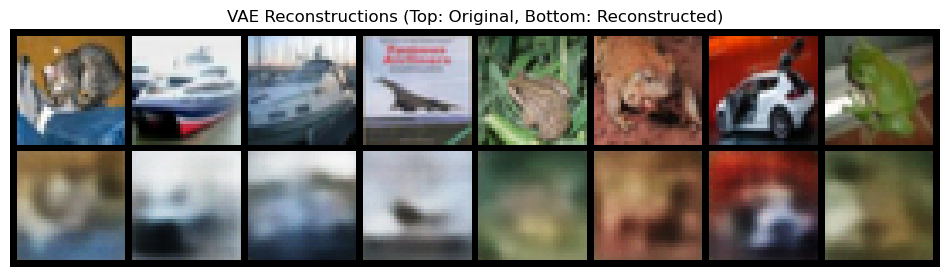

Generating latent interpolations...


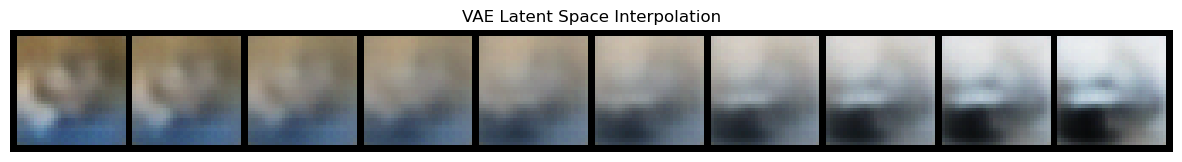

In [8]:
def evaluate_vae_reconstructions(model, test_loader, n_samples=8):
    """Generate reconstruction grid"""
    model.eval()
    with torch.no_grad():
        test_batch, _ = next(iter(test_loader))
        test_batch = test_batch[:n_samples].to(device)
        recon, _, _ = model(test_batch)
        
        # Concatenate original and reconstructed
        comparison = torch.cat([test_batch, recon])
        comparison = comparison * 0.5 + 0.5  # Denormalize
        
        # Save
        save_image(comparison.cpu(), 'results/vae_recons.png', nrow=n_samples)
        
        # Display
        grid = make_grid(comparison.cpu(), nrow=n_samples)
        plt.figure(figsize=(12, 6))
        plt.imshow(grid.permute(1, 2, 0))
        plt.title('VAE Reconstructions (Top: Original, Bottom: Reconstructed)')
        plt.axis('off')
        plt.savefig('figures/vae_reconstructions.png', dpi=150, bbox_inches='tight')
        plt.show()

def latent_interpolation(model, test_loader, n_interp=10):
    """Interpolate between two images in latent space"""
    model.eval()
    with torch.no_grad():
        test_batch, _ = next(iter(test_loader))
        img1, img2 = test_batch[0:1].to(device), test_batch[1:2].to(device)
        
        # Encode
        mu1, _ = model.encode(img1)
        mu2, _ = model.encode(img2)
        
        # Interpolate
        alphas = torch.linspace(0, 1, n_interp).to(device)
        interpolations = []
        
        for alpha in alphas:
            z_interp = (1 - alpha) * mu1 + alpha * mu2
            img_interp = model.decode(z_interp)
            interpolations.append(img_interp)
        
        interpolations = torch.cat(interpolations)
        interpolations = interpolations * 0.5 + 0.5  # Denormalize
        
        # Save and display
        save_image(interpolations.cpu(), 'results/vae_interpolation.png', nrow=n_interp)
        
        grid = make_grid(interpolations.cpu(), nrow=n_interp)
        plt.figure(figsize=(15, 3))
        plt.imshow(grid.permute(1, 2, 0))
        plt.title('VAE Latent Space Interpolation')
        plt.axis('off')
        plt.savefig('figures/vae_interpolation.png', dpi=150, bbox_inches='tight')
        plt.show()

# Evaluate VAE
print("Generating VAE reconstructions...")
evaluate_vae_reconstructions(vae, test_loader)

print("Generating latent interpolations...")
latent_interpolation(vae, test_loader)

## 9. Linear Probe on Frozen VAE Latents

In [9]:
def extract_vae_features(model, data_loader, max_samples=10000):
    """Extract VAE latent representations"""
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for images, lbls in tqdm(data_loader, desc='Extracting features'):
            images = images.to(device)
            mu, _ = model.encode(images)
            features.append(mu.cpu())
            labels.append(lbls)
            
            if len(features) * data_loader.batch_size >= max_samples:
                break
    
    features = torch.cat(features).numpy()
    labels = torch.cat(labels).numpy()
    
    return features[:max_samples], labels[:max_samples]

def linear_probe_evaluation(model, train_loader, test_loader):
    """Train linear classifier on frozen VAE latents"""
    print("Extracting training features...")
    train_features, train_labels = extract_vae_features(model, train_loader)
    
    print("Extracting test features...")
    test_features, test_labels = extract_vae_features(model, test_loader)
    
    print("Training linear classifier...")
    clf = LogisticRegression(max_iter=1000, random_state=SEED, n_jobs=-1)
    clf.fit(train_features, train_labels)
    
    # Evaluate
    train_pred = clf.predict(train_features)
    test_pred = clf.predict(test_features)
    
    train_acc = accuracy_score(train_labels, train_pred)
    test_acc = accuracy_score(test_labels, test_pred)
    
    results = {
        'train_accuracy': float(train_acc),
        'test_accuracy': float(test_acc)
    }
    
    print(f"Linear Probe Results:")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    
    # Save results
    with open('results/linear_probe.csv', 'w') as f:
        f.write('metric,value\n')
        f.write(f'train_accuracy,{train_acc:.4f}\n')
        f.write(f'test_accuracy,{test_acc:.4f}\n')
    
    return results

# Run linear probe
linear_probe_results = linear_probe_evaluation(vae, train_loader, test_loader)

Extracting training features...


Extracting features:  99%|█████████▉| 156/157 [00:14<00:00, 10.66it/s]


Extracting test features...


Extracting features:  99%|█████████▉| 156/157 [00:13<00:00, 11.96it/s] 

Training linear classifier...


Linear Probe Results:
  Train Accuracy: 0.4056
  Test Accuracy: 0.3769


## 10. GAN Sample Generation

Generating GAN samples...


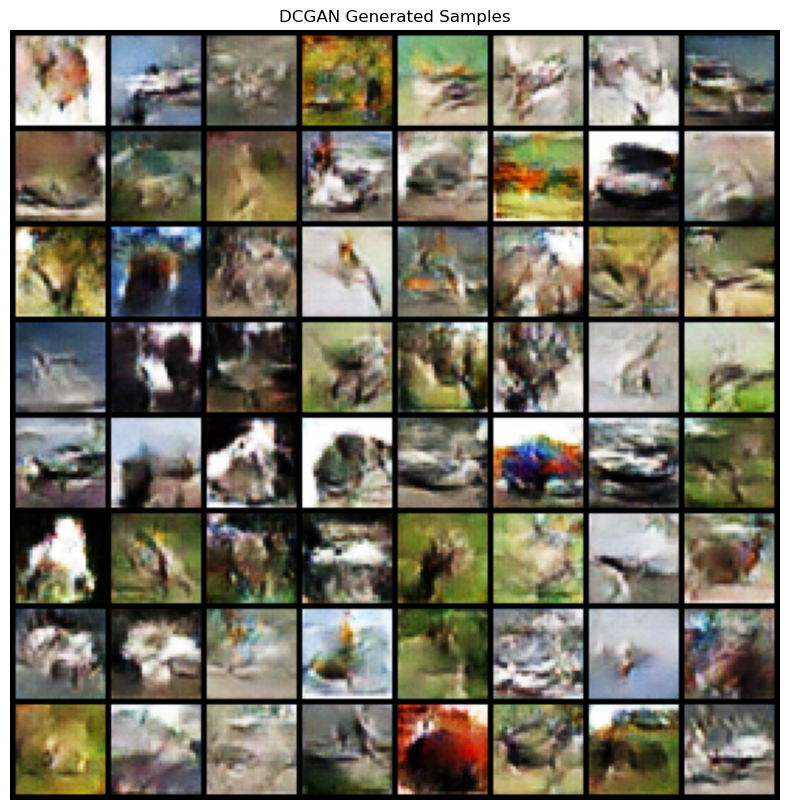

In [10]:
def generate_gan_samples(generator, n_samples=64, z_dim=100):
    """Generate samples from GAN"""
    generator.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, z_dim).to(device)
        samples = generator(z)
        samples = samples * 0.5 + 0.5  # Denormalize
        
        # Save
        save_image(samples.cpu(), 'results/gan_samples.png', nrow=8)
        
        # Display
        grid = make_grid(samples.cpu(), nrow=8)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0))
        plt.title('DCGAN Generated Samples')
        plt.axis('off')
        plt.savefig('figures/gan_samples.png', dpi=150, bbox_inches='tight')
        plt.show()

# Generate samples
print("Generating GAN samples...")
generate_gan_samples(generator, n_samples=64, z_dim=Z_DIM)

## 11. FID Score Calculation

In [11]:
# Note: For FID calculation, we need to install pytorch-fid
# Run: pip install pytorch-fid

def generate_images_for_fid(generator, n_samples=2000, z_dim=100, save_dir='fid_fake'):
    """Generate images for FID calculation"""
    os.makedirs(save_dir, exist_ok=True)
    
    generator.eval()
    with torch.no_grad():
        for i in tqdm(range(0, n_samples, BATCH_SIZE), desc='Generating for FID'):
            batch_size = min(BATCH_SIZE, n_samples - i)
            z = torch.randn(batch_size, z_dim).to(device)
            samples = generator(z)
            samples = samples * 0.5 + 0.5  # Denormalize to [0, 1]
            
            for j, img in enumerate(samples):
                save_image(img, f'{save_dir}/img_{i+j}.png')

def save_real_images_for_fid(data_loader, n_samples=2000, save_dir='fid_real'):
    """Save real images for FID calculation"""
    os.makedirs(save_dir, exist_ok=True)
    
    count = 0
    for images, _ in tqdm(data_loader, desc='Saving real images'):
        images = images * 0.5 + 0.5  # Denormalize
        for img in images:
            if count >= n_samples:
                return
            save_image(img, f'{save_dir}/img_{count}.png')
            count += 1

# Generate images for FID
N_FID_SAMPLES = 2000  # Use 2k samples as per instructions

print("Generating fake images for FID...")
generate_images_for_fid(generator, n_samples=N_FID_SAMPLES, z_dim=Z_DIM)

print("Saving real images for FID...")
save_real_images_for_fid(test_loader, n_samples=N_FID_SAMPLES)

print("\nTo calculate FID, run the following command:")
print("pytorch-fid fid_real fid_fake --device cuda")
print("\nOr use the provided script in reproduce.sh")

Generating fake images for FID...


Generating for FID: 100%|██████████| 32/32 [00:03<00:00,  9.86it/s]


Saving real images for FID...


Saving real images:  20%|█▉        | 31/157 [00:14<00:57,  2.21it/s]


To calculate FID, run the following command:
pytorch-fid fid_real fid_fake --device cuda

Or use the provided script in reproduce.sh


## 12. Training History Visualization

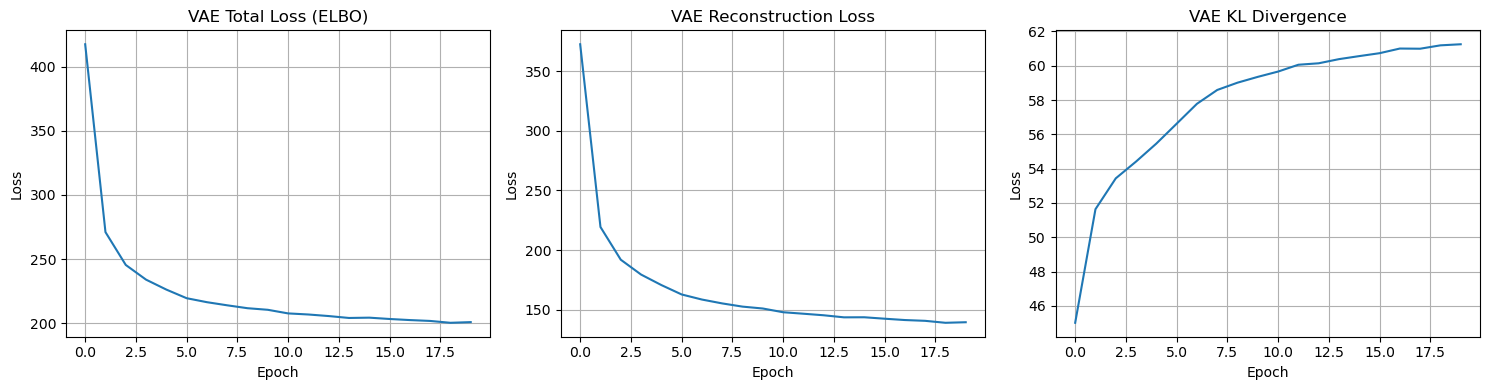

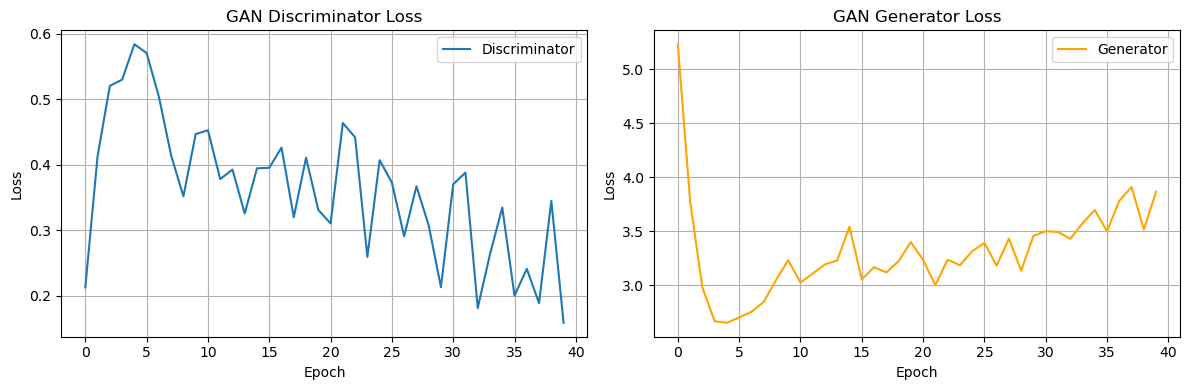

In [12]:
# Plot VAE training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(vae_history['total_loss'])
axes[0].set_title('VAE Total Loss (ELBO)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

axes[1].plot(vae_history['recon_loss'])
axes[1].set_title('VAE Reconstruction Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(True)

axes[2].plot(vae_history['kl_loss'])
axes[2].set_title('VAE KL Divergence')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('figures/vae_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot GAN training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(gan_history['d_loss'], label='Discriminator')
axes[0].set_title('GAN Discriminator Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(gan_history['g_loss'], label='Generator', color='orange')
axes[1].set_title('GAN Generator Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.savefig('figures/gan_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## 13. Summary of Results

In [13]:
# Compile all results
results_summary = {
    'vae': {
        'final_elbo': vae_history['total_loss'][-1],
        'final_recon_loss': vae_history['recon_loss'][-1],
        'final_kl_loss': vae_history['kl_loss'][-1],
        'linear_probe_accuracy': linear_probe_results['test_accuracy']
    },
    'gan': {
        'final_d_loss': gan_history['d_loss'][-1],
        'final_g_loss': gan_history['g_loss'][-1],
        'fid_note': 'Run pytorch-fid to get FID score'
    },
    'hyperparameters': {
        'seed': SEED,
        'vae_epochs': VAE_EPOCHS,
        'gan_epochs': GAN_EPOCHS,
        'vae_latent_dim': 64,
        'gan_z_dim': Z_DIM,
        'batch_size': BATCH_SIZE
    }
}

# Save summary
with open('results/summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
print("\nVAE Results:")
print(f"  Final ELBO: {results_summary['vae']['final_elbo']:.4f}")
print(f"  Final Reconstruction Loss: {results_summary['vae']['final_recon_loss']:.4f}")
print(f"  Final KL Divergence: {results_summary['vae']['final_kl_loss']:.4f}")
print(f"  Linear Probe Accuracy: {results_summary['vae']['linear_probe_accuracy']:.4f}")

print("\nGAN Results:")
print(f"  Final Discriminator Loss: {results_summary['gan']['final_d_loss']:.4f}")
print(f"  Final Generator Loss: {results_summary['gan']['final_g_loss']:.4f}")
print(f"  FID Score: Run 'pytorch-fid fid_real fid_fake' to calculate")

print("\nAll results saved to:")
print("  - results/vae_recons.png")
print("  - results/gan_samples.png")
print("  - results/linear_probe.csv")
print("  - results/summary.json")
print("  - checkpoints/vae_model.pth")
print("  - checkpoints/gan_model.pth")
print("="*60)


RESULTS SUMMARY

VAE Results:
  Final ELBO: 200.8168
  Final Reconstruction Loss: 139.5634
  Final KL Divergence: 61.2534
  Linear Probe Accuracy: 0.3769

GAN Results:
  Final Discriminator Loss: 0.1586
  Final Generator Loss: 3.8660
  FID Score: Run 'pytorch-fid fid_real fid_fake' to calculate

All results saved to:
  - results/vae_recons.png
  - results/gan_samples.png
  - results/linear_probe.csv
  - results/summary.json
  - checkpoints/vae_model.pth
  - checkpoints/gan_model.pth


## 14. Analysis: Observed Failure Modes

### VAE Failure Modes

**Failure Mode 1: Posterior Collapse**
- The KL divergence term can dominate, causing the model to ignore the latent code
- Decoder learns to generate average images regardless of z
- **Mitigation**: β-VAE with β < 1 or KL annealing (gradually increase β during training)

**Failure Mode 2: Blurry Reconstructions**
- MSE/BCE loss causes averaging of possible outputs
- High-frequency details are lost
- **Mitigation**: Use perceptual loss or adversarial training (VAE-GAN)

### GAN Failure Modes

**Failure Mode 1: Mode Collapse**
- Generator produces limited variety of samples
- Fails to capture full data distribution
- **Mitigation**: Minibatch discrimination, unrolled GAN, or spectral normalization

**Failure Mode 2: Training Instability**
- Oscillating losses, no convergence
- Generator and discriminator fail to reach equilibrium
- **Mitigation**: Two-timescale update rule (TTUR), gradient penalty (WGAN-GP), or spectral normalization
